<a href="https://colab.research.google.com/github/rajy4683/S15FinalSubmission/blob/master/S15Unet_FunctionProfiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Thu May 21 13:00:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys

import os
#print(os.environ['CUDA_LAUNCH_BLOCKING'])

In [0]:
sys.path.append('/content/drive/My Drive/EVA4/RekogNizer')
sys.path.append('/content/drive/My Drive/EVA4')
sys.path.append('/content/drive/My Drive/EVA4/DenseDepth')

### Dependencies


In [0]:
!pip install -r /content/drive/My\ Drive/EVA4/RekogNizer/requirements.txt

In [0]:
!pip install -U git+https://github.com/albu/albumentations

In [0]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random
from google.colab.patches import cv2_imshow
from PIL import Image
import glob
import pandas as pd

import torch
from zipfile import ZipFile
import re
import h5py
import time



In [0]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import torchvision.transforms as transforms
from RekogNizer import hyperparams


from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, MotionBlur
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, RandomBrightnessContrast,
    Resize,RandomSizedCrop, MotionBlur,MultiplicativeNoise,InvertImg, IAAFliplr,
	IAAPerspective,
)
from albumentations.pytorch import ToTensor
import random

from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
import os
import sys
import numpy as np
from torchvision import datasets
#from RekogNizer import imgnetloader
from RekogNizer import basemodelclass
from RekogNizer import mmdlrfinder

from RekogNizer import mmdtraintest
from RekogNizer import mmddataloader
from RekogNizer import mmdlosses
from RekogNizer import mmdmodels

from RekogNizer import hyperparams
from RekogNizer import fileutils

from torch.utils.data import Dataset
import shutil
from tqdm import tqdm
from RekogNizer import mmdmodels

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, CyclicLR, ReduceLROnPlateau


import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import wandb

  pip install torch-lr-finder -v --global-option="amp"
  pip install torch-lr-finder -v --global-option="amp"


In [0]:
!rm -rf /content/train && mkdir -p /content/train
!rm -rf /content/test && mkdir -p /content/test

In [0]:
%%time
csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
batch_start = 0
batch_end = batch_start+5000
dest_dir="/content/train"

#mmddataloader.extract_data_files_mt(csv_file, root_dir, batch_start,batch_end, dest_dir=dest_dir)


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [0]:
#%%time 
size_hw = (224,224)

dest_dir="/content/train"
train_batch_size = 32
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, dest_dir, batch_start,batch_end, read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':8,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)

In [0]:
i,o1, o2 = iter(train_loader).next()

In [0]:
i.shape,o1.shape,o2.shape

(torch.Size([32, 6, 224, 224]),
 torch.Size([32, 1, 224, 224]),
 torch.Size([32, 1, 224, 224]))

In [0]:
test_csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTest.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
test_batch_start = 0
test_batch_end = test_batch_start + 100
test_dest_dir = "/content/test"

#mmddataloader.extract_data_files(test_csv_file, root_dir, test_batch_start,test_batch_end, dest_dir=test_dest_dir)

In [0]:
size_hw = (224,224)
test_dest_dir = "/content/test"
test_batch_size=32
test_dataset = mmddataloader.DepthMaskDataSet(test_csv_file, test_dest_dir, test_batch_start,test_batch_end,read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':4,'pin_memory': True}
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

In [0]:
import traceback
def profile_dataloader(data_loader, sample_count=500000):
    pbar = tqdm(data_loader)
    for batch_idx, dataset in enumerate(pbar):
        #traceback.print_stack()
        data_len = len(dataset['input'])
        if(batch_idx > sample_count):
            #traceback.print_stack()
            break
    #traceback.print_stack()


In [0]:
%%time

In [0]:
profile_dataloader(train_loader,1)

In [0]:
%%time 
profile_dataloader(train_loader)

100%|██████████| 391/391 [05:55<00:00,  1.10it/s]

CPU times: user 2.86 s, sys: 2.75 s, total: 5.61 s
Wall time: 5min 55s


### Dataloader profiling:
`DataSet = {'input': [6, 224, 224], 'output': [[224,224], [224,224]]}`
For 100K (i.e 100Kx4)


1.   Size: (224,224) Batch Size: 128
```
Time Taken: CPU times: user 33.4 s, sys: 37.3 s, total: 1min 10s
Wall time: 12min 7s
```
2.   Size: (224,224) Batch Size: 64
```
CPU times: user 36.6 s, sys: 39.6 s, total: 1min 16s
Wall time: 12min 52s
```
3.   Size: (56,56) Batch Size: 256
```
CPU times: user 2.86 s, sys: 2.75 s, total: 5.61 s
Wall time: 5min 55s
```








In [0]:
def print_dataloader_stack():
    
    traceback.print_stack()

In [0]:
import cProfile

In [0]:
cProfile.run('depth_dataset[100]')

In [0]:
cProfile.run('profile_dataloader(train_loader)')

In [0]:
iter(train_loader).next()['input'].shape

torch.Size([101, 6, 56, 56])

In [0]:
size_hw = (224,224)
dest_dir="/content/train"
train_batch_size = 8
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, dest_dir, batch_start,batch_end, read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':4,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)

In [0]:
from RekogNizer import mmdtraintest
from RekogNizer import mmdlosses

criterion={"mask":[mmdlosses.LocalBCELoss, mmdlosses.LocalSSIMLoss ], 
           "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}

#criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss, mmdlosses.LocalSSIMLoss ], "depth":[mmdlosses.LocalRMSELoss]}
#model = basemodelclass.MonoMaskDepthResNetFunc()
optimizer=optim.SGD(model_new.parameters(), lr=0.001,momentum=0.9,  weight_decay=0)
lrfinder = mmdtraintest.find_lr_type1(model_new, optimizer, criterion, train_loader, testloader=None, seed=1, start_lr=0.0001, end_lr=1, step_mode="exp",num_iter=100)



Learning rate search finished. See the graph with {finder_name}.plot()


0.02754228703338166 1.0 0.8153246641159058
{'lr': [0.00010964781961431851, 0.0001202264434617413, 0.0001318256738556407, 0.00014454397707459274, 0.00015848931924611136, 0.00017378008287493755, 0.00019054607179632473, 0.00020892961308540398, 0.00022908676527677731, 0.000251188643150958, 0.0002754228703338166, 0.00030199517204020164, 0.00033113112148259116, 0.0003630780547701014, 0.00039810717055349724, 0.00043651583224016605, 0.00047863009232263843, 0.0005248074602497726, 0.000575439937337157, 0.0006309573444801934, 0.0006918309709189364, 0.0007585775750291837, 0.0008317637711026711, 0.0009120108393559097, 0.001, 0.0010964781961431851, 0.0012022644346174132, 0.0013182567385564075, 0.0014454397707459273, 0.0015848931924611134, 0.0017378008287493754, 0.0019054607179632473, 0.00208929613085404, 0.0022908676527677737, 0.0025118864315095794, 0.0027542287033381664, 0.003019951720402016, 0.0033113112148259113, 0.0036307805477010144, 0.003981071705534973, 0.004365158322401658, 0.004786300923226

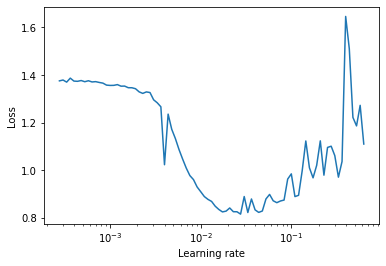

In [0]:
min_lr = lrfinder.history['lr'][np.argmin(lrfinder.history['loss'])]
max_lr = np.max(lrfinder.history['lr'])
print(min_lr, max_lr, np.min(lrfinder.history['loss']))
print(lrfinder.history)
lrfinder.plot()

In [0]:
summary(model_new, input_size=(6,64,64)  )

In [0]:
del model
torch.cuda.empty_cache()

In [0]:
lrfinder.reset()

In [0]:
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)
expand_model  =mmdmodels.CustomUNet(model_new,n_channels=6, n_classes=2)
# model_new = mmdtraintest.load_model_for_infer(model_new, 
#                                   '/content/drive/My Drive/EVA4/model_saves/model-30d31a02c7.h5',
#                                   device)

In [0]:
expand_model = mmdtraintest.load_model_for_infer(expand_model, 
                                  '/content/drive/My Drive/EVA4/model_saves/model-2b6defd394.h5',
                                  device)
model_new_params = ['baseUNet.'+param[0] for param in list(model_new.named_parameters()) ]
expand_model_params = [param[1] for param in list(expand_model.named_parameters()) if param[0] not in model_new_params]

In [0]:
for parameter in model_new.parameters():
    print(parameter.requires_grad)# = False

In [0]:
expand_model.named_parameters()

In [0]:
model_new_params = ['baseUNet.'+param[0] for param in list(model_new.named_parameters()) ]
expand_model_params = [  ]
for param in list(expand_model.named_parameters()):
    if re.search('up',param[0]) or (param[0] not in model_new_params):
        expand_model_params.append(param[1])
    

In [0]:
len(expand_model_params)

51

In [0]:
len(model_new_params),len(expand_model_params), len(list(expand_model.parameters()))

(74, 19, 93)

In [0]:
len(expand_model_params)

19

In [0]:
pr.print_stats()

         1094989 function calls (1054467 primitive calls) in 181.691 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:147(__enter__)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:211(_call_with_frames_removed)
       21    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:222(_verbose_message)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstra

In [0]:
!mkdir -p /content/wandb/run-20200516_161642-3naldsdk/

Baseline model save path: '/content/drive/My Drive/EVA4/model_saves/model-2d84393326.h5'  

In [0]:
torch.save({
    'model_state_dict': model_new.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/drive/My Drive/EVA4/baseline_models/64_RekNet_BRM.h5')

In [0]:
del expand_model
torch.cuda.empty_cache()

In [0]:
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
#model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)
model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)
expand_model  =mmdmodels.CustomUNet(model_new,n_channels=6, n_classes=2)
expand_model = mmdtraintest.load_model_for_infer(expand_model, 
                                  '/content/drive/My Drive/EVA4/model_saves/model-fa59faa675.h5',
                                  device)


In [0]:
img = iter(test_loader).next()
with torch.no_grad():
    output_val = model_new(img[0].to(device))

In [0]:
output_pred = torch.split(output_val,1,dim=1)

In [0]:
%%time
mmdlosses.LocalSSIMLoss(output_pred[0],img[2])

CPU times: user 617 ms, sys: 11.1 ms, total: 628 ms
Wall time: 628 ms


tensor(0.4929)

In [0]:
mmdtraintest.display_samples_new(expand_model, test_loader, device)

In [0]:
output_pred[0][0],torch.sigmoid(output_pred[0][0])

In [0]:
#loss_func = [mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss, mmdlosses.LocalPixelLoss, mmdlosses.LocalBCELoss, mmdlosses.dice_loss]
#loss_func = [mmdlosses.LocalRMSELoss,  mmdlosses.LocalPixelLoss, mmdlosses.LocalBCELoss, mmdlosses.dice_loss]
loss_func = [mmdlosses.LocalSSIMLoss]
pr = cProfile.Profile()
pr.enable()
for loss_val in loss_func:    
    own_loss = 1#loss_val(img['output'][0],img['output'][0])
    pred_loss = loss_val(output_pred[1].to(device),img[2].to(device))
    #print("Own loss:{} Pred Loss:{} Diff:{}".format(own_loss, pred_loss, torch.abs(pred_loss/own_loss)))
pr.disable()
#mmdlosses.LocalRMSELoss(output_pred[0],img['output'][0])
pr.print_stats()

         294 function calls in 0.059 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-43-de63fac48051>:10(<module>)
        1    0.000    0.000    0.058    0.058 <ipython-input-43-de63fac48051>:6(<module>)
        2    0.000    0.000    0.000    0.000 __init__.py:167(is_tensor)
        5    0.000    0.000    0.000    0.000 __init__.py:1917(is_scripting)
        2    0.000    0.000    0.000    0.000 codeop.py:132(__call__)
        5    0.000    0.000    0.000    0.000 filter.py:14(<listcomp>)
        5    0.000    0.000    0.050    0.010 filter.py:23(filter2D)
        5    0.000    0.000    0.000    0.000 filter.py:9(compute_padding)
        5    0.000    0.000    0.001    0.000 functional.py:3327(_pad)
        2    0.000    0.000    0.000    0.000 hooks.py:139(__call__)
        2    0.000    0.000    0.000    0.000 hooks.py:204(pre_run_code_hook)
        2    0.000